<a href="https://colab.research.google.com/github/ash8m/cost-analysis/blob/main/Copy_of_BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_file, to_categorical


tf.random.set_seed(123)

In [37]:
DATA_NAME = "PneumoniaMNIST"
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]


--2024-03-15 15:48:14--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py.1’

info.py.1           100%[===================>]  27.12K  --.-KB/s    in 0.002s  

2024-03-15 15:48:14 (14.9 MB/s) - ‘info.py.1’ saved [27766/27766]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset = np.load('/content/drive/MyDrive/'+DATA_NAME.lower()+'.npz')


Mounted at /content/drive


In [ ]:
# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_x = np.expand_dims(train_x, axis=-1)  # Add an extra dimension for the color channel
train_x = tf.image.resize(train_x, (32, 32))  # Resize the images to 32x32
train_x = tf.repeat(train_x, 3, axis=-1)  # Convert grayscale images to RGB
train_x = train_x / 255.0  # Normalize the images
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_x = np.expand_dims(val_x, axis=-1)
val_x = tf.image.resize(val_x, (32, 32))
val_x = tf.repeat(val_x, 3, axis=-1)
val_x = val_x / 255.0
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_x = np.expand_dims(test_x, axis=-1)
test_x = tf.image.resize(test_x, (32, 32))
test_x = tf.repeat(test_x, 3, axis=-1)
test_x = test_x / 255.0
test_y = dataset["test_labels"]


In [ ]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]
print(labels)
# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

['normal', 'pneumonia', 'total']
           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


In [ ]:
# Load the pre-trained model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
print(len(base_model.layers))

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
logits = layers.Dense(1)(x)
# outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, logits)

#model.compile(optimizer=tf.keras.optimizers.Adam(),
#              loss=tf.keras.losses.BinaryCrossentropy(),
#              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()


16705208/16705208 [==============================] - 0s 0us/step
238
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                          

In [ ]:
# Train the model
history = model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))


Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# Unfreeze the whole base model for fine-tuning
base_model.trainable = True
# unfreeze the last 15 layers
#num_layers = len(base_model.layers)
#for layer in base_model.layers[:num_layers - 15]:
#    layer.trainable = False
#for layer in base_model.layers[num_layers - 15:]:
#    layer.trainable = True


model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Fine-tune the model
fine_tune_epochs = 15
total_epochs = 5+15


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513   

In [ ]:
history_fine = model.fit(train_x, train_y,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(val_x, val_y))

Epoch 5/20
148/148 [==============================] - 75s 332ms/step - loss: 0.5717 - binary_accuracy: 0.7421 - val_loss: 0.5708 - val_binary_accuracy: 0.7424
Epoch 6/20
148/148 [==============================] - 46s 311ms/step - loss: 0.5695 - binary_accuracy: 0.7421 - val_loss: 0.5666 - val_binary_accuracy: 0.7424
Epoch 7/20
148/148 [==============================] - 47s 319ms/step - loss: 0.5538 - binary_accuracy: 0.7428 - val_loss: 0.6392 - val_binary_accuracy: 0.7424
Epoch 8/20
148/148 [==============================] - 48s 324ms/step - loss: 0.4041 - binary_accuracy: 0.8180 - val_loss: 0.3239 - val_binary_accuracy: 0.8263
Epoch 9/20
148/148 [==============================] - 46s 310ms/step - loss: 0.3422 - binary_accuracy: 0.8407 - val_loss: 0.3896 - val_binary_accuracy: 0.8454
Epoch 10/20
148/148 [==============================] - 46s 311ms/step - loss: 0.3275 - binary_accuracy: 0.8522 - val_loss: 0.2732 - val_binary_accuracy: 0.8817
Epoch 11/20
148/148 [========================

In [ ]:
model.save_weights("/content/drive/MyDrive/fine_tuned_weights.h5", save_format="h5")
model.save("/content/drive/MyDrive/fine_tuned_model.keras")

NameError: name 'model' is not defined

In [ ]:
model.evaluate(test_x, test_y)

20/20 [==============================] - 4s 70ms/step - loss: 0.3314 - binary_accuracy: 0.8814


[0.33139267563819885, 0.8814102411270142]

In [ ]:
#model = tf.keras.models.load_model("/content/drive/MyDrive/fine_tuned_model.keras")
model.load_weights("/content/drive/MyDrive/fine_tuned_weights.h5")

In [ ]:
model.summary()
print(model.predict(np.expand_dims(test_x[30], axis=0)))
print(model.layers[-1].name)
print(model.layers[-1].output_shape)
print(model.layers[-1].output)
print(model.layers[-1].activation.__name__)
weights, biases = model.layers[-1].get_weights()
# Print the shapes of the weights and biases
print("Weights shape:", weights.shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513   

In [ ]:

# Create the final layer with sigmoid activation
#calibration_layer = layers.Dense(1, activation='sigmoid', kernel_initializer='ones')(model.output)

# Create a new model combining the pre-trained model and final layer
#prob_model = tf.keras.Model(inputs=model.input, outputs=calibration_layer)


In [65]:
from tensorflow.keras import Model
from keras.initializers import Constant
initializer = Constant(0.2)

class UnCalibratedModel(Model):
  def __init__(self, base_model):
    super(UnCalibratedModel, self).__init__()
    self.base_model = base_model

    self.sigmoid_layer = layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)

  def call(self, inputs):
    x = self.base_model(inputs)
    return self.sigmoid_layer(x)

# Load and freeze the pre-trained model

# Create the calibration model
prob_model = UnCalibratedModel(model)


In [ ]:
#model.trainable = 'false'
#prob_model = 0
#prob_model = tf.keras.models.Sequential([model, layers.Dense(1, activation='sigmoid')])

#prob_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
#              loss=tf.keras.losses.BinaryCrossentropy(),
#              metrics=[tf.keras.metrics.BinaryAccuracy()])

#prob_model.summary()
#history = prob_model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))


In [66]:
#prob_model.summary()
print(prob_model.predict(np.expand_dims(test_x[30], axis=0)))
print(prob_model.layers[-1].name)
#print(prob_model.layers[-1].output_shape)
#print(prob_model.layers[-1].activation.__name__)
#print(prob_model.layers[-1])

weights, biases = prob_model.layers[-1].get_weights()
# Print the shapes of the weights and biases
print("Weights :", weights)
if biases is not None:
  print("Biases :", biases)

predictions_none = prob_model.predict(test_x)
print(test_y[0:5].flatten())
print(predictions_none[0:5].flatten())

# Create a DataFrame with the original labels and the predicted probabilities
df = pd.DataFrame({
    'label': test_y.flatten(),
    'prediction': predictions_none.flatten()  # Flatten to make it 1D
})

# Specify the path to your Google Drive and the filename
path = "/content/drive/MyDrive/predictions_none.csv"

# Save the DataFrame to a CSV file in Google Drive
df.to_csv(path, index=False)

1/1 [==============================] - 3s 3s/step
[[0.47313908]]
dense_4
Weights : [[0.2]]
Biases : [0.]
20/20 [==============================] - 1s 45ms/step
[1 0 1 0 1]
[0.726966   0.7137143  0.47611582 0.36892176 0.7317378 ]


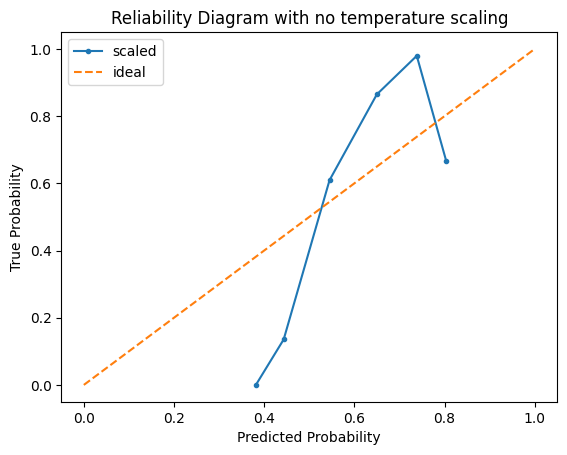

In [67]:
from sklearn.calibration import calibration_curve

prob_true_2, prob_pred_2 = calibration_curve(test_y.flatten(), predictions_none.flatten(), n_bins=10)
plt.plot(prob_pred_2, prob_true_2, marker='.', label="scaled")
plt.plot([0, 1], [0, 1], linestyle='--', label="ideal")
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Diagram with no temperature scaling')
plt.legend()
plt.show()

define a modified sigmoid function which can be used in the final temperature scaled layer

In [ ]:
def temperature_scaled_sigmoid(logits: tf.Tensor, temperature: float = 1.0) -> tf.Tensor:
  """
  Applies temperature scaled sigmoid activation to a tensor of logits.

  Args:
      logits: A TensorFlow tensor of logits with shape [batch_size, 1].
      temperature: A floating-point value controlling the "softness" of the output.

  Returns:
      A TensorFlow tensor of probabilities with shape [batch_size, 1].
  """
  scaled_logits = logits / temperature
  return tf.sigmoid(scaled_logits)


define the final layer which uses the modified temperature scaled sigmoid

In [ ]:
class TemperatureScaledSigmoid(tf.keras.layers.Layer):
    def __init__(self, temperature: float = 1):
        super(TemperatureScaledSigmoid, self).__init__()
        self.temperature = temperature

    def call(self, logits: tf.Tensor, train: bool = False):
        return temperature_scaled_sigmoid(logits, temperature=self.temperature)

In [ ]:
validation_logits = model.predict(val_x)
validation_logits.shape

17/17 [==============================] - 1s 48ms/step


(524, 1)

Prep a dataset with the logits and corresponding labels to be used to learn the temperature parameter

In [39]:
N_EPOCHS = 20
data = tf.data.Dataset.from_tensor_slices((validation_logits, val_y)).repeat(N_EPOCHS)

create a custom model which can be used for training to learn the temperature parameter

In [ ]:
class CalibrationModel(Model):
    def __init__(self):
        super().__init__()
        self.temperature = tf.Variable(1.0)

    def call(self, logits: tf.Tensor):
        return logits / self.temperature

In [ ]:
calibration_model = CalibrationModel()

In [59]:
def loss(labels: tf.Tensor, logits: tf.Tensor):
    """Loss function"""
    return tf.nn.sigmoid_cross_entropy_with_logits(labels, logits)


optimiser = tf.optimizers.Adam(learning_rate=1e-4)


def train(model: Model, x: tf.Tensor, y: tf.Tensor) -> tf.Tensor:
    with tf.GradientTape() as tape:
        logits = model(x)
        #print(f"x shape: {x.shape}")
        #print(f"logits shape: {logits.shape}")
        #print(f"y type: {y.dtype}")
        y = tf.cast(y, tf.float32)  # or tf.float64
        #print(f"y shape: {y.shape}")
        _loss = loss(y, logits)
    gradients = tape.gradient(_loss, [model.temperature])
    optimiser.apply_gradients(zip(gradients, model.trainable_variables))
    return _loss.numpy().mean()

In [60]:
from tqdm import tqdm
history = []
step = 0

for epoch in tqdm(range(N_EPOCHS)):
    for i, (_x, _y) in enumerate(data.batch(32)):
        try:
            _loss = train(calibration_model, _x, _y)
            history.append(
                {
                    "loss": _loss,
                    "epoch": epoch,
                    "step": step,
                    "temperature": calibration_model.temperature.numpy(),
                }
            )
            step += 1
        except tf.errors.InvalidArgumentError:
            history.append(
                {
                    "loss": 100,
                    "epoch": 100,
                    "step": 100,
                    "temperature": 100,
                }
            )
            break
history = pd.DataFrame(history)

100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


<Axes: xlabel='step', ylabel='temperature'>

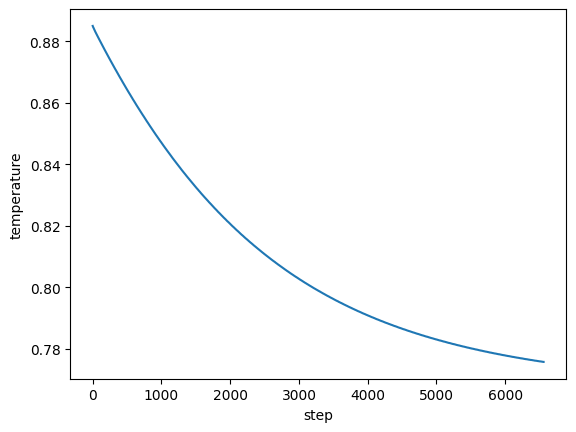

In [61]:
sns.lineplot(data=history, x="step", y="temperature")

<Axes: xlabel='epoch'>

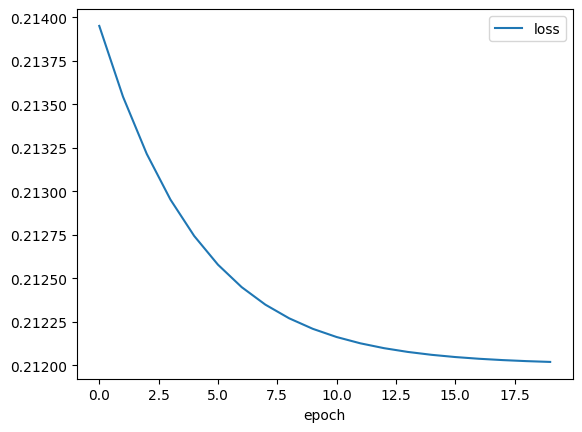

In [62]:
history.groupby("epoch").mean().plot(y="loss")

In [63]:
calibrated_model = tf.keras.models.Sequential(
    [model, TemperatureScaledSigmoid(temperature=calibration_model.temperature.numpy())]
)
predictions_temp = calibrated_model.predict(test_x)
print(test_y[0:5].flatten())
print(predictions_temp[0:5].flatten())

# Create a DataFrame with the original labels and the predicted probabilities
df = pd.DataFrame({
    'label': test_y.flatten(),
    'prediction': predictions_temp.flatten()  # Flatten to make it 1D
})

# Specify the path to your Google Drive and the filename
path = "/content/drive/MyDrive/predictions_temp.csv"

# Save the DataFrame to a CSV file in Google Drive
df.to_csv(path, index=False)

20/20 [==============================] - 3s 52ms/step
[1 0 1 0 1]
[0.99818975 0.99723625 0.35062313 0.03045678 0.9984506 ]


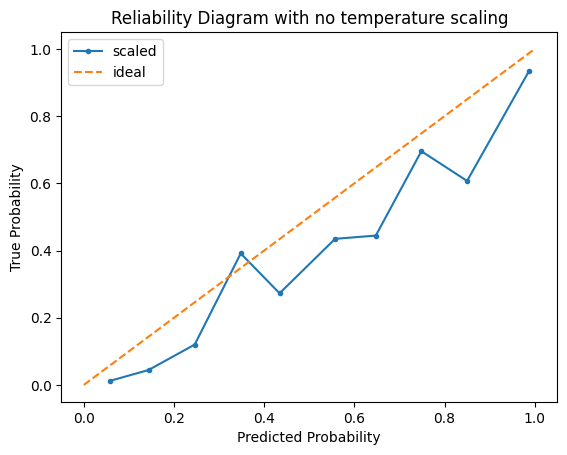

In [64]:
from sklearn.calibration import calibration_curve

prob_true_2, prob_pred_2 = calibration_curve(test_y.flatten(), predictions_temp.flatten(), n_bins=10)
plt.plot(prob_pred_2, prob_true_2, marker='.', label="scaled")
plt.plot([0, 1], [0, 1], linestyle='--', label="ideal")
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Diagram with no temperature scaling')
plt.legend()
plt.show()